In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul  1 01:49:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install --upgrade mxnet-cu110
!pip install --upgrade gluoncv

     |████████████████████████████████| 323.5MB 48kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 1.3MB 8.7MB/s 


In [4]:
import shutil
import pandas as pd
import numpy as np 
import os
import cv2
import re

from PIL import Image

from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.model_selection import StratifiedKFold, train_test_split
import joblib

In [5]:
if(os.path.isdir('train')):
  print('folder exists, skip unzip procedure')
else:
  shutil.copyfile('/content/drive/MyDrive/aicrowd_wheat/train.zip','/content/train.zip')
  shutil.unpack_archive('./train.zip')
  #!unzip train.zip

In [6]:
len(os.listdir('./train/')), os.listdir('./train/')[0:3]

(3655,
 ['7cdf0e65ad9b58b01214ba958416f52d6af4a5e86e9735b1e6c790496abc7ed2.png',
  '56a4e3f48fd900b5aebb991ddad9ea78e15c116f97f5e76d9b3bef7102847fa0.png',
  'c700bec9a2755e42c49ce4db0c14a098f46fbbfd6e1d4ab32e7db802ba1a63ff.png'])

In [7]:
df_train = pd.read_csv('./train.csv')
df_train['image_id'] = df_train['image_name']
df_train['has_no_boxes'] = np.where(df_train['BoxesString']=='no_box',1,0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_name    3657 non-null   object
 1   BoxesString   3657 non-null   object
 2   domain        3657 non-null   int64 
 3   image_id      3657 non-null   object
 4   has_no_boxes  3657 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 143.0+ KB


In [8]:
df_train['has_no_boxes'].sum()*100/df_train.shape[0]

1.3672409078479628

In [9]:
df_noboxes = df_train.groupby(['domain'])['has_no_boxes'].agg(['sum','count']).reset_index()
df_noboxes['perc'] = df_noboxes['sum']*100/df_noboxes['count']
df_noboxes

,domain,sum,count,perc
0,0,0,29,0.000000
1,1,2,60,3.333333
2,2,0,176,0.000000
3,3,0,20,0.000000
4,4,0,24,0.000000
5,5,46,448,10.267857
6,6,0,160,0.000000
7,7,0,60,0.000000
8,8,0,32,0.000000
9,9,0,82,0.000000


In [10]:
df_train[df_train.BoxesString=='no_box'].shape[0], \
df_train[df_train.BoxesString=='no_box'].shape[0]*100/df_train.shape[0]

(50, 1.3672409078479628)

### Filter images with multiple domains

In [11]:
tf = df_train[['image_id','domain']].groupby(['image_id']).count().reset_index()
domain_lkup = df_train[~df_train.image_id.isin(tf[tf.domain>1].image_id.values)][['image_id','domain']]
tf[tf.domain>1].image_id.values

array(['73d4c61b8be64a946df940e3e5cdceecb662960363c84a29fb8e99d4b660fa0e',
       '8ec1474b9cdc0fd870b443439daa56660c57140c051a8a49052d22d828728f12'],
      dtype=object)

In [12]:
df_train_final = pd.concat([pd.Series(row['image_id'], row['BoxesString'].split(';')) \
                            for _, row in df_train[df_train.BoxesString!='no_box'].iterrows()]).reset_index()
df_train_final.columns = ['box','image_id']
df_train_final['x_min'] = df_train_final.box.apply(lambda x:x.split(' ')[0]).apply(int)
df_train_final['y_min'] = df_train_final.box.apply(lambda x:x.split(' ')[1]).apply(int)
df_train_final['x_max'] = df_train_final.box.apply(lambda x:x.split(' ')[2]).apply(int)
df_train_final['y_max'] = df_train_final.box.apply(lambda x:x.split(' ')[3]).apply(int)
df_train_final['x'] = df_train_final['x_min']
df_train_final['y'] = df_train_final['y_min']
df_train_final['w'] = df_train_final['x_max'] - df_train_final['x_min']
df_train_final['h'] = df_train_final['y_max'] - df_train_final['y_min']
df_train_final = df_train_final.merge(domain_lkup, on=['image_id'], how='left')
df_train_final.fillna(-1, inplace=True)
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163690 entries, 0 to 163689
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   box       163690 non-null  object 
 1   image_id  163690 non-null  object 
 2   x_min     163690 non-null  int64  
 3   y_min     163690 non-null  int64  
 4   x_max     163690 non-null  int64  
 5   y_max     163690 non-null  int64  
 6   x         163690 non-null  int64  
 7   y         163690 non-null  int64  
 8   w         163690 non-null  int64  
 9   h         163690 non-null  int64  
 10  domain    163690 non-null  float64
dtypes: float64(1), int64(8), object(2)
memory usage: 15.0+ MB


In [13]:
df_train_final.head()
# df_train.domain.value_counts()

,box,image_id,x_min,y_min,x_max,y_max,x,y,w,h,domain
0,949 967 999 994,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,949,967,999,994,949,967,50,27,0.0
1,368 649 443 685,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,368,649,443,685,368,649,75,36,0.0
2,118 280 185 333,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,118,280,185,333,118,280,67,53,0.0
3,899 564 947 609,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,899,564,947,609,899,564,48,45,0.0
4,604 243 682 297,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,604,243,682,297,604,243,78,54,0.0


In [14]:
DIR_INPUT = './'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [15]:
train_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/train_set')
test_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/test_set')
kfold_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/kfolds')
train_images.shape, test_images.shape, len(kfold_images)

((2925,), (732,), 5)

In [16]:
valid_df = df_train_final[df_train_final['image_id'].isin(test_images)]
train_df = df_train_final#[df_train_final['image_id'].isin(train_images)]
valid_df.shape, train_df.shape

((32281, 11), (163690, 11))

In [17]:
img_id = train_df.image_id.sample(1).values[0]
bboxes = np.array([np.array(i.split(' '), dtype='int') for i in train_df[train_df.image_id==img_id].box.values])
train_image = Image.open('./train/'+img_id+'.png')
train_image = np.array(train_image)
len(bboxes)

61

In [18]:
df_train_final.head()

,box,image_id,x_min,y_min,x_max,y_max,x,y,w,h,domain
0,949 967 999 994,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,949,967,999,994,949,967,50,27,0.0
1,368 649 443 685,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,368,649,443,685,368,649,75,36,0.0
2,118 280 185 333,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,118,280,185,333,118,280,67,53,0.0
3,899 564 947 609,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,899,564,947,609,899,564,48,45,0.0
4,604 243 682 297,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,604,243,682,297,604,243,78,54,0.0


In [19]:
root = '/content/'

In [20]:
import os
import cv2
import copy
import json
import random
import numpy as np
import mxnet as mx
import pandas as pd
import gluoncv as gcv
from multiprocessing import cpu_count
from multiprocessing.dummy import Pool


def load_dataset(root):
    # csv = pd.read_csv(os.path.join(root, "train.csv"))
    csv = df_train_final
    data = {}
    for i in csv.index:
        key = csv["image_id"][i]
        bbox = [int(i) for  i in csv["box"][i].split(' ')]
        bbox = [bbox[0], bbox[1], bbox[2], bbox[3], 0.0]
        if key in data:
            data[key].append(bbox)
        else:
            data[key] = [bbox]
    return sorted(
        [(k, os.path.join(root, "train", k + ".png"), v) for k, v in data.items()],
        key=lambda x: x[0]
    )

def load_image(path):
    with open(path, "rb") as f:
        buf = f.read()
    return mx.image.imdecode(buf)

def get_batches(dataset, batch_size, width=1024, height=1024, net=None, ctx=mx.cpu()):
    batches = len(dataset) // batch_size
    sampler = Sampler(dataset, width, height, net)
    stack_fn = [gcv.data.batchify.Stack()]
    pad_fn = [gcv.data.batchify.Pad(pad_val=-1)]
    if net is None:
        batchify_fn = gcv.data.batchify.Tuple(*(stack_fn + pad_fn))
    else:
        batchify_fn = gcv.data.batchify.Tuple(*(stack_fn * 6 + pad_fn))
    with Pool(cpu_count() * 2) as p:
        for i in range(batches):
            start = i * batch_size
            samples = p.map(sampler, range(start, start + batch_size))
            batch = batchify_fn(samples)
            yield [x.as_in_context(ctx) for x in batch]

def gauss_blur(image, level):
    return cv2.blur(image, (level * 2 + 1, level * 2 + 1))

def gauss_noise(image):
    for i in range(image.shape[2]):
        c = image[:, :, i]
        diff = 255 - c.max();
        noise = np.random.normal(0, random.randint(1, 6), c.shape)
        noise = (noise - noise.min()) / (noise.max() - noise.min())
        noise = diff * noise
        image[:, :, i] = c + noise.astype(np.uint8)
    return image


# This class was modified from YOLO3DefaultTrainTransform of GluonCV
class YOLO3TrainTransform:
    def __init__(self, width, height, net, mean=(0.485, 0.456, 0.406),
                 std=(0.229, 0.224, 0.225), **kwargs):
        self._width = width
        self._height = height
        self._mean = mean
        self._std = std

        # in case network has reset_ctx to gpu
        self._fake_x = mx.nd.zeros((1, 3, height, width))
        net = copy.deepcopy(net)
        net.collect_params().reset_ctx(None)
        with mx.autograd.train_mode():
            _, self._anchors, self._offsets, self._feat_maps, _, _, _, _ = net(self._fake_x)
        self._target_generator = gcv.model_zoo.yolo.yolo_target.YOLOV3PrefetchTargetGenerator(
            num_class=len(net.classes), **kwargs)

    def __call__(self, img, label):
        # random expansion with prob 0.5
        if np.random.uniform(0, 1) > 0.5:
            img, expand = gcv.data.transforms.image.random_expand(img, max_ratio=1.5, fill=114, keep_ratio=False)
            bbox = gcv.data.transforms.bbox.translate(label, x_offset=expand[0], y_offset=expand[1])
        else:
            img, bbox = img, label

        # random cropping
        h, w, _ = img.shape
        bbox, crop = gcv.data.transforms.experimental.bbox.random_crop_with_constraints(bbox, (w, h))
        x0, y0, w, h = crop
        img = mx.image.fixed_crop(img, x0, y0, w, h)

        # resize with random interpolation
        h, w, _ = img.shape
        interp = np.random.randint(0, 5)
        img = gcv.data.transforms.image.imresize(img, self._width, self._height, interp=interp)
        bbox = gcv.data.transforms.bbox.resize(bbox, (w, h), (self._width, self._height))

        # random horizontal&vertical flip
        h, w, _ = img.shape
        img, flips = gcv.data.transforms.image.random_flip(img, px=0.5, py=0.5)
        bbox = gcv.data.transforms.bbox.flip(bbox, (w, h), flip_x=flips[0], flip_y=flips[1])

        # random color jittering
        img = gcv.data.transforms.experimental.image.random_color_distort(img)

        # to tensor
        img = mx.nd.image.to_tensor(img)
        img = mx.nd.image.normalize(img, mean=self._mean, std=self._std)

        # generate training target so cpu workers can help reduce the workload on gpu
        gt_bboxes = mx.nd.array(bbox[np.newaxis, :, :4])
        gt_ids = mx.nd.array(bbox[np.newaxis, :, 4:5])
        gt_mixratio = mx.nd.array(bbox[np.newaxis, :, -1:])
        objectness, center_targets, scale_targets, weights, class_targets = self._target_generator(
            self._fake_x, self._feat_maps, self._anchors, self._offsets,
            gt_bboxes, gt_ids, gt_mixratio)
        return (img, objectness[0], center_targets[0], scale_targets[0], weights[0],
                class_targets[0], gt_bboxes[0])


class Sampler:
    def __init__(self, dataset, width, height, net=None, **kwargs):
        self._dataset = dataset
        if net is None:
            self._training_mode = False
            self._transform = gcv.data.transforms.presets.yolo.YOLO3DefaultValTransform(width, height, **kwargs)
        else:
            self._training_mode = True
            self._transform = YOLO3TrainTransform(width, height, net, **kwargs)

    def __call__(self, idx):
        if self._training_mode:
            raw, bboxes = self._load_mixup(idx)
            raw = raw.asnumpy()
            blur = random.randint(0, 3)
            if blur > 0:
                raw = gauss_blur(raw, blur)
            raw = gauss_noise(raw)
            h, w, _ = raw.shape
            rot = random.randint(0, 3)
            if rot > 0:
                raw = np.rot90(raw, k=rot)
                if rot == 1:
                    raw_bboxes = bboxes.copy()
                    bboxes[:, [0, 2]] = raw_bboxes[:, [1, 3]]
                    bboxes[:, [1, 3]] = w - raw_bboxes[:, [2, 0]]
                elif rot == 2:
                    bboxes[:, [0, 1, 2, 3]] = np.array([[w, h, w, h]]) - bboxes[:, [2, 3, 0, 1]]
                elif rot == 3:
                    raw_bboxes = bboxes.copy()
                    bboxes[:, [0, 2]] = h - raw_bboxes[:, [1, 3]]
                    bboxes[:, [1, 3]] = raw_bboxes[:, [2, 0]]
                raw_bboxes = bboxes.copy()
                bboxes[:, 0] = np.min(raw_bboxes[:, [0, 2]], axis=1)
                bboxes[:, 1] = np.min(raw_bboxes[:, [1, 3]], axis=1)
                bboxes[:, 2] = np.max(raw_bboxes[:, [0, 2]], axis=1)
                bboxes[:, 3] = np.max(raw_bboxes[:, [1, 3]], axis=1)
            raw = mx.nd.array(raw)
        else:
            raw = load_image(self._dataset[idx][1])
            bboxes = np.array(self._dataset[idx][2])
        res = self._transform(raw, bboxes)
        return [mx.nd.array(x) for x in res]

    def _load_mixup(self, idx1):
        r = random.gauss(0.5, 0.5 / 1.96)
        if r > 0.0:
            raw1 = load_image(self._dataset[idx1][1])
            bboxes1 = np.array(self._dataset[idx1][2])
            if r >= 1.0:
                return raw1, np.hstack([bboxes1, np.full((bboxes1.shape[0], 1), 1.0)])
        idx2 = random.randint(0, len(self._dataset) - 1)
        raw2 = load_image(self._dataset[idx2][1])
        bboxes2 = np.array(self._dataset[idx2][2])
        if r <= 0.0:
            return raw2, np.hstack([bboxes2, np.full((bboxes2.shape[0], 1), 1.0)])
        h = max(raw1.shape[0], raw2.shape[0])
        w = max(raw1.shape[1], raw2.shape[1])
        mix_raw = mx.nd.zeros(shape=(h, w, 3), dtype="float32")
        mix_raw[:raw1.shape[0], :raw1.shape[1], :] += raw1.astype("float32") * r
        mix_raw[:raw2.shape[0], :raw2.shape[1], :] += raw2.astype("float32") * (1.0 - r)
        mix_bboxes = np.vstack([
            np.hstack([bboxes1, np.full((bboxes1.shape[0], 1), r)]),
            np.hstack([bboxes2, np.full((bboxes2.shape[0], 1), 1.0 - r)])
        ])
        return mix_raw.astype("uint8"), mix_bboxes

def reconstruct_color(img):
    mean = mx.nd.array([0.485, 0.456, 0.406])
    std = mx.nd.array([0.229, 0.224, 0.225])
    return ((img * std + mean).clip(0.0, 1.0) * 255).astype("uint8")

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.9.0+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [21]:
import mxnet as mx
import gluoncv as gcv
import warnings

#net = gcv.model_zoo.yolo3_darknet53_custom(["wheat"], pretrained_base=False)
#net.set_nms(post_nms=150)
#net.load_parameters(path, ctx=ctx)

ctx = mx.gpu()
net = gcv.model_zoo.yolo3_darknet53_custom(["wheat"], transfer="voc", ctx=ctx)
net.set_nms(post_nms=150)
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    net.initialize(mx.init.Xavier(), ctx=ctx)

223070KB [00:03, 55897.24KB/s]                            


dataset preview:  [('000be778dbb878bf22db3a3525d9722d7f2a49a3a1fb49321c1a43beabd88c06', '/content/train/000be778dbb878bf22db3a3525d9722d7f2a49a3a1fb49321c1a43beabd88c06.png', [[259, 948, 313, 1018, 0.0], [912, 698, 984, 754, 0.0], [463, 528, 540, 596, 0.0], [221, 0, 290, 57, 0.0], [606, 532, 693, 616, 0.0], [15, 778, 130, 846, 0.0], [349, 711, 403, 776, 0.0], [184, 526, 262, 611, 0.0], [497, 703, 617, 770, 0.0], [102, 814, 159, 875, 0.0], [828, 686, 915, 749, 0.0], [51, 64, 124, 164, 0.0], [100, 283, 199, 354, 0.0], [775, 31, 853, 97, 0.0], [178, 67, 246, 141, 0.0], [359, 396, 433, 489, 0.0], [883, 67, 949, 127, 0.0], [118, 595, 208, 653, 0.0], [394, 821, 501, 895, 0.0], [964, 221, 1024, 282, 0.0], [620, 763, 696, 829, 0.0], [1, 253, 82, 316, 0.0], [685, 90, 787, 164, 0.0], [549, 254, 622, 328, 0.0], [319, 943, 375, 1024, 0.0], [51, 874, 118, 960, 0.0], [691, 420, 765, 513, 0.0], [42, 647, 124, 711, 0.0], [617, 704, 687, 766, 0.0], [964, 86, 1024, 177, 0.0], [0, 444, 29, 513, 0.0], [76

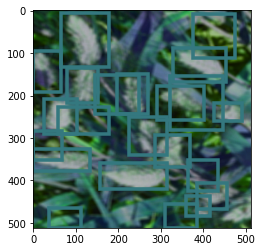

/content/train/001be48ccfab560e650dc0a4cceeb1636844520c88267e215ec9987688566931.png


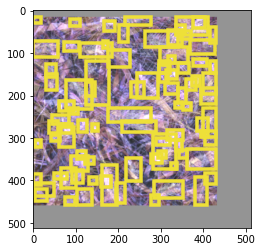

/content/train/003c89679439f746a046c4a89aad17ff32d4e0fe0be96c17518a8f972f31b30d.png


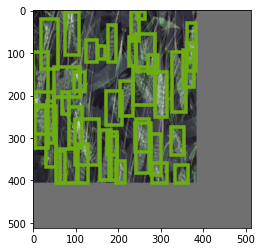

In [22]:
data = load_dataset("/content/")
print("dataset preview: ", data[:3])
print("max count of bboxes: ", max([len(bboxes) for _, _, bboxes in data]))
# print("training batch preview: ", next(get_batches(data, 4, net=net)))
# print("validation batch preview: ", next(get_batches(data, 4)))
import matplotlib.pyplot as plt
print("data visual preview: ")
sampler = Sampler(data, 512, 512, net)
for i, x in enumerate(data[0:3]):
    print(x[1])
    y = sampler(i)
    gcv.utils.viz.plot_bbox(reconstruct_color(y[0].transpose((1, 2, 0))), y[6])
    plt.show()

In [23]:
val_k = 0
folds = 0
dataset = data.copy()
learning_rate = 0.001
sgd = None
use_amp = False
start_epoch = 0
max_epochs = 5
batch_size = 3
img_w = 1024
img_h = 1024

In [24]:
if val_k < folds:
    print("Splitting %d-folds: " % folds, val_k)
    fold_size = math.ceil(len(dataset) / folds)
    split = (val_k * fold_size, (val_k + 1) * fold_size)
    training_set = dataset[:split[0]] + dataset[split[1]:]
    validation_set = dataset[split[0]:split[1]]
else:
    split = int(len(dataset) * 0.9)
    training_set = dataset[:split]
    validation_set = dataset[split:]
print("Training set: ", len(training_set))
print("Validation set: ", len(validation_set))

Training set:  3244
Validation set:  361


In [25]:
def load_model(path, ctx=mx.cpu()):
    net = gcv.model_zoo.yolo3_darknet53_custom(["wheat"], pretrained_base=False)
    net.set_nms(post_nms=150)
    net.load_parameters(path, ctx=ctx)
    return net
'''if os.path.isfile("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53.params"):
    model = load_model("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53.params", 
                       ctx=ctx)'''
if os.path.isfile("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/kaggle_top_pretrained.params"):
    model = load_model("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/kaggle_top_pretrained.params", 
                       ctx=ctx)
else:
    model = net
metrics = [gcv.utils.metrics.VOCMApMetric(iou_thresh=iou) for iou in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]]

In [26]:
if sgd:
    print("Optimizer: SGD")
    trainer = mx.gluon.Trainer(model.collect_params(), "SGD", {
        "learning_rate": learning_rate,
        "momentum": 0.5
    }, kvstore='local', update_on_kvstore=False)
else:
    print("Optimizer: Nadam")
    trainer = mx.gluon.Trainer(model.collect_params(), "Nadam", {
        "learning_rate": learning_rate
    }, kvstore='local', update_on_kvstore=False)

from mxnet.contrib import amp

if use_amp:
    amp.init()
    amp.init_trainer(trainer)
'''if os.path.isfile("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53.state"):
  print('loading previous state')
  trainer.load_states("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53.state")'''

Optimizer: Nadam


'if os.path.isfile("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53.state"):\n  print(\'loading previous state\')\n  trainer.load_states("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53.state")'

In [27]:
import time

print("Training...", flush=True)
scores_progress = []
best_score = 0.0
for epoch in range(start_epoch, max_epochs):
    ts = time.time()

    random.shuffle(training_set)
    training_total_L = 0.0
    training_batches = 0
    for x, objectness, center_targets, scale_targets, weights, class_targets, gt_bboxes in get_batches(training_set, batch_size, width=img_w, height=img_h, net=model, ctx=ctx):
        training_batches += 1
        with mx.autograd.record():
            obj_loss, center_loss, scale_loss, cls_loss = model(x, gt_bboxes, objectness, center_targets, scale_targets, weights, class_targets)
            L = obj_loss + center_loss + scale_loss + cls_loss
            if use_amp:
                with amp.scale_loss(L, trainer) as scaled_L:
                    scaled_L.backward()
            else:
                L.backward()
        trainer.step(x.shape[0])
        training_batch_L = mx.nd.mean(L).asscalar()
        if training_batch_L != training_batch_L:
            raise ValueError()
        training_total_L += training_batch_L
        print("[Epoch %d  Batch %d]  batch_loss %.10f  average_loss %.10f  elapsed %.2fs" % (
            epoch, training_batches, training_batch_L, training_total_L / training_batches, time.time() - ts
        ), flush=True)
    training_avg_L = training_total_L / training_batches

    for metric in metrics:
        metric.reset()
    for x, label in get_batches(validation_set, batch_size, width=img_w, height=img_h, ctx=ctx):
        classes, scores, bboxes = model(x)
        for metric in metrics:
            metric.update(
                bboxes,
                classes.reshape((0, -1)),
                scores.reshape((0, -1)),
                label[:, :, :4],
                label[:, :, 4:5].reshape((0, -1))
            )
    score = mx.nd.array([metric.get()[1] for metric in metrics], ctx=ctx).mean()
    scores_progress.append(score.asscalar())

    if score.asscalar() > best_score:
        best_score = score.asscalar()
        model.save_parameters("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53_best.params")

    print("[Epoch %d]  training_loss %.10f  validation_score %.10f  best_score %.10f  duration %.2fs" % (
        epoch + 1, training_avg_L, score.asscalar(), best_score, time.time() - ts
    ), flush=True)

    model.save_parameters("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53.params")
    trainer.save_states("/content/drive/MyDrive/aicrowd_wheat/gluon_yolo/global-wheat-yolo3-darknet53.state")

Streaming output truncated to the last 5000 lines.
[Epoch 0  Batch 411]  batch_loss 312.3641662598  average_loss 218.1656021898  elapsed 1109.89s
[Epoch 0  Batch 412]  batch_loss 244.8471679688  average_loss 218.2303632718  elapsed 1112.57s
[Epoch 0  Batch 413]  batch_loss 179.4927825928  average_loss 218.1365676769  elapsed 1115.11s
[Epoch 0  Batch 414]  batch_loss 120.6871414185  average_loss 217.9011825893  elapsed 1117.44s
[Epoch 0  Batch 415]  batch_loss 216.9977264404  average_loss 217.8990055866  elapsed 1119.97s
[Epoch 0  Batch 416]  batch_loss 282.8848571777  average_loss 218.0552215760  elapsed 1122.74s
[Epoch 0  Batch 417]  batch_loss 296.6153564453  average_loss 218.2436151848  elapsed 1125.65s
[Epoch 0  Batch 418]  batch_loss 157.2254486084  average_loss 218.0976387097  elapsed 1128.10s
[Epoch 0  Batch 419]  batch_loss 320.6356201172  average_loss 218.3423594290  elapsed 1131.06s
[Epoch 0  Batch 420]  batch_loss 213.8886718750  average_loss 218.3317554111  elapsed 1133.65s

In [28]:
scores_progress

[0.72435373, 0.73348516, 0.7274471, 0.72612214, 0.73510116]

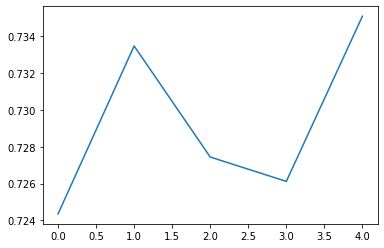

In [29]:
plt.plot(scores_progress)